In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from scipy import stats
import astropy.units as u
import astropy.constants as c

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

## 1. PBH

In [11]:
mass_s, inj_s, sigma_s = np.loadtxt(f"{WDIR}/outputs/limits/pbh_limits.txt", unpack=True)

In [3]:
plot_names = {
    'limits' : ['Voyager', 'Comptel', 'CMBevap', 'INTEGRAL_NEW'],
    'edges_limits' : ['EDGESevap-Mittal2021', 'EDGESevap-Clark2018', 'EDGESevap-Saha2021'],
    'forecasts' : ['amego'],
    'extras' : ['EGRB', 'LeoTevap', '511keV', 'INTEGRAL', 'SuperK'],
}
plot_names_all = []
for t, fns in plot_names.items():
    plot_names_all += fns

data = {}
for plot_name in plot_names_all:
    m, f = np.loadtxt(f"{WDIR}/data/limits/pbh/{plot_name}.txt", unpack=True) # [Msun], [1]
    m_g = m * (c.M_sun.to(u.g)).value # [g], [1]
    data[plot_name] = dict(m=m_g, f=f)

In [4]:
def ccmap(x):
    purple = np.array(cms['Purples'](1.0))
    #black = np.array([0, 0, 0, 1])
    blue = np.array(cms['Blues'](1.0))
    white = np.array([1, 1, 1, 1])
    color1 = purple
    color2 = blue * 0.5 + white * 0.5
    color = color1 * x + color2 * (1 - x)
    return tuple(color)

colors = {
    'CMBevap' : cms['binary'](0.8),
    'Voyager' :      ccmap(0.6),
    'INTEGRAL_NEW' : ccmap(0.3),
    'Comptel' :      ccmap(0.0),
    'amego' : cms['Reds'](0.8),
}
linestyles = {
    'EDGESevap-Clark2018' : '--',
    'EDGESevap-Mittal2021' : ':',
    'EDGESevap-Saha2021' : '-.',
}
labels = {
    'CMBevap' : 'Planck',
    'Voyager' : 'Voyager',
    'INTEGRAL_NEW' : 'Integral',
    'EGRB' : 'EGRB',
    'LeoTevap' : 'Leo T',
    'Comptel' : 'Comptel',
    'amego' : 'AMEGO (proj.)',
    'EDGESevap-Clark2018' : 'EDGES Clark 2018',
    'EDGESevap-Mittal2021' : 'EDGES Mittal 2021',
    'EDGESevap-Saha2021' : 'EDGES Saha 2021',
}
zorders = {
    'CMBevap' : -1,
    'Voyager' : -2,
    'INTEGRAL_NEW' : -2.5,
    'EGRB' : -3,
    'LeoTevap' : -4,
    'Comptel' : -5,
    'amego' : 10,
    'EDGESevap-Clark2018' : 6,
    'EDGESevap-Mittal2021' : 6,
    'EDGESevap-Saha2021' : 6,
}

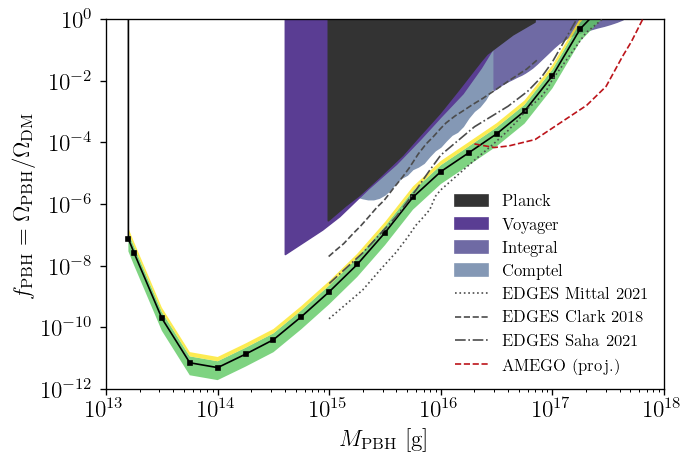

In [13]:
extras = False
edges = True

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

one_sigma = inj_s * sigma_s
upper_limit = np.sqrt(stats.chi2.ppf(.9, df=1)) * one_sigma

f_max = 1e10

# other limits
ims = []
for n in plot_names['limits']:
    ims.append(ax.fill_between(data[n]['m'], data[n]['f'], f_max, label=labels[n], color=colors[n], zorder=zorders[n]))
if edges:
    for n in plot_names['edges_limits']:
        ims.append(ax.plot(data[n]['m'], data[n]['f'], lw=1, linestyle=linestyles[n], label=labels[n], color=cms['binary'](0.7), zorder=zorders[n]))
for n in plot_names['forecasts']:
    ims.append(ax.plot(data[n]['m'], data[n]['f'], lw=1, label=labels[n], ls='--', color=colors[n], zorder=zorders[n]))
if extras:
    for n in plot_names['extras']:
        ims.append(ax.plot(data[n]['m'], data[n]['f'], lw=1, label=n, zorder=10))

# our limits
ax.plot(mass_s, upper_limit, 'k-s', lw=1, ms=2)
ax.fill_between(mass_s, upper_limit+one_sigma, upper_limit-one_sigma, color=mpl.colormaps['viridis'](0.75), alpha=0.8, ec='none')
ax.fill_between(mass_s, upper_limit+2*one_sigma, upper_limit+one_sigma, color=mpl.colormaps['viridis'](1.0), alpha=0.8, ec='none')

ax.set(xscale='log', yscale='log')
ax.set(xlabel=r'$M_\mathrm{PBH}$ [g]', ylabel=r'$f_\mathrm{PBH}=\Omega_\mathrm{PBH}/\Omega_\mathrm{DM}$')
ax.set(ylim=(1e-12, 1e0), xlim=(1e13, 1e18))
#ax.legend(loc='lower right', frameon=False, fontsize=10)
#ax.legend(loc='lower right')

handles, handle_labels = plt.gca().get_legend_handles_labels()
if edges:
    order = [2, 0, 3, 1, 4, 5, 6, 7]
    ax.legend([handles[idx] for idx in order], [handle_labels[idx] for idx in order], loc='lower right', frameon=False, fontsize=10)
else:
    order = [2, 0, 3, 1, 4]
    ax.legend([handles[idx] for idx in order], [handle_labels[idx] for idx in order], loc='lower right', frameon=False, fontsize=10)

fig.savefig('pbh_limits.pdf', bbox_inches='tight', dpi=300)

In [37]:
labels

['Voyager',
 'Comptel',
 'Planck',
 'Integral',
 'EDGES Mittal 2021',
 'EDGES Clark 2018',
 'EDGES Saha 2021',
 'AMEGO (proj.)']